In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math



> Roos WH, Wuite GJL. Nanoindentation Studies Reveal Material Properties of Viruses. Adv Mater 2009;21:1187–92. https://doi.org/10.1002/adma.200801709.





# Manufacturing



In [7]:
#Argon tank capacity
ar_tank = 80 #cu.ft at STP
ar_tank *= 0.0283 #to cubic meters
ar_tank /= (1/15) # backfill pressure

chamber_volume = 0.04*0.1*0.1

ar_tank / chamber_volume





84900.0

In [52]:
# Alumina per shot

mix_density = 4.0 #g/cc
mix_density *= 1e6 #g/m^3

board_volume = (0.00078)*0.07*0.07

board_volume * mix_density
board_volume * mix_density + 5.0 #waste

20.288000000000004

#### Multi-layer insulation

From Wikipedia (https://en.wikipedia.org/wiki/Multi-layer_insulation):

Simplified two-flux method:

$ Q=UA\Delta T$

$ U = 4 \sigma T_{average}^3 \frac{1}{N(2/\epsilon-1)+1}$

Where $\sigma$ is the Stefan-Boltzmann constant, Delta T is the temperature difference between the interior and exterior layers, and T_average is the average temperature of all the layers. This breaks if the layer temperature difference is enormous.

https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20080013560.pdf

For comparison, alumina silicate insulation is typically 0.12 W/(m K).

In [16]:
Thot = 1200.0+273.15 #Kelvin
Tcold = 273.0 #Kelvin
Tave = (Thot + Tcold) / 2.0 #Not accurate

area = (0.0254*2+0.045*2)*0.05 + 0.0254*0.045*2

N = 2
emissivity = 1

Q = area*(Thot - Tcold)* (Tave**3.0)*4.0*(5.67e-8)*(1.0/(N*((2.0/emissivity) - 1.0)+1.0))
Q


563.1283526602356

112.34636042534004

In [29]:
vol = (math.pi*((0.048/2.0)**2.0) - math.pi*(((0.048/2.0)-0.001)**2.0)) * 0.05

(vol / 1e-6)*4

(vol / 1e-6)*4


29.530970943744077

# Required market penetration

SIR epidemic model from:

https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

(Thanks!)

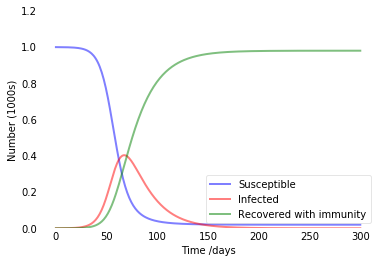

In [27]:
# Total population, N.
N = 7000000000.0
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1000000, 50000
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
# β describes the effective contact rate of the disease: 
# an infected individual comes into contact with βN other individuals per unit time
beta, gamma = 0.2, 1./20 
# A grid of time points (in days)
t = np.linspace(0, 300, 300)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()